In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6,7"

import pickle
import random
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig
import joblib
import logging
from datetime import datetime
from argparse import ArgumentParser
import src.utils as utils
from src.utils import normalize_answer, find_subsequence, exact_match_score
import json
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

/drive2/ryusejong/miniconda3/envs/dagcd/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#data = utils.load_parquet_data('results/llama-2-7b-hf/HotpotQA-2000-0.2per-seed0-gen.parquet')
data = utils.load_parquet_data('results/llama-2-7b-hf/HotpotQA-2000-2per-seed0-gen-v2.parquet')
#data = utils.load_parquet_data('results/llama-2-7b-hf/HotpotQA-train-2000-1per-seed0-gen.parquet')

# evaluate Greedy
print('------------------Greedy------------------')
greedy_em, _, _ = utils.evaluate_em(data, 'gold_ans', 'greedy_ans')
greedy_f1, _, _ = utils.evaluate_f1(data, 'gold_ans', 'greedy_ans')

print(f"EM: {greedy_em * 100}")
print(f"F1: {greedy_f1 * 100}\n")

# evaluate RAG Hallu
print('------------------RAG Hallu------------------')
ours_em, _, _ = utils.evaluate_em(data, 'gold_ans', 'pred_ans')
ours_f1, _, _ = utils.evaluate_f1(data, 'gold_ans', 'pred_ans')


print(f"EM: {ours_em * 100}")
print(f"F1: {ours_f1 * 100}\n")

------------------Greedy------------------
EM: 43.22
F1: 53.61

------------------RAG Hallu------------------
EM: 43.22
F1: 53.61



In [5]:
correct = []
incorrect = []
correct_score1 = []
incorrect_score1 = []
correct_score2 = []
incorrect_score2 = []

for i, item in enumerate(data):

    if exact_match_score(item['gold_ans'][0], item['pred_ans']):
        correct.append(item)
        correct_score1.append(item['greedy_score1'])
        correct_score2.append(item['greedy_score2'])
    else:
        incorrect.append(item)
        incorrect_score1.append(item['greedy_score1'])
        incorrect_score2.append(item['greedy_score2'])

print('-'*50)
print(f"Total correct: {100 * len(correct) / len(data): .2f}%")
print('-'*50)
print(f"Correct score1: {np.mean(correct_score1): .4f}")
print(f"Incorrect score1: {np.mean(incorrect_score1): .4f}")
print('-'*50)
print(f"Correct score2: {np.mean(correct_score2): .4f}")
print(f"Incorrect score2: {np.mean(incorrect_score2): .4f}")

--------------------------------------------------
Total correct:  43.22%
--------------------------------------------------
Correct score1: -0.1119
Incorrect score1: -0.1240
--------------------------------------------------
Correct score2: -0.1899
Incorrect score2: -0.3358


/tmp/ipykernel_37200/629187256.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot([correct_score1, incorrect_score1], labels=['Correct', 'Incorrect'])
/tmp/ipykernel_37200/629187256.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot([correct_score2, incorrect_score2], labels=['Correct', 'Incorrect'])


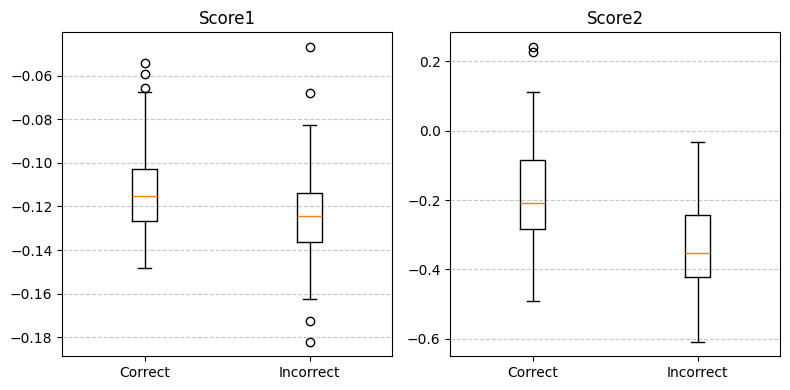

In [8]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot 1: Score1
axes[0].boxplot([correct_score1, incorrect_score1], labels=['Correct', 'Incorrect'])
axes[0].set_title('Score1')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Score2
axes[1].boxplot([correct_score2, incorrect_score2], labels=['Correct', 'Incorrect'])
axes[1].set_title('Score2')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

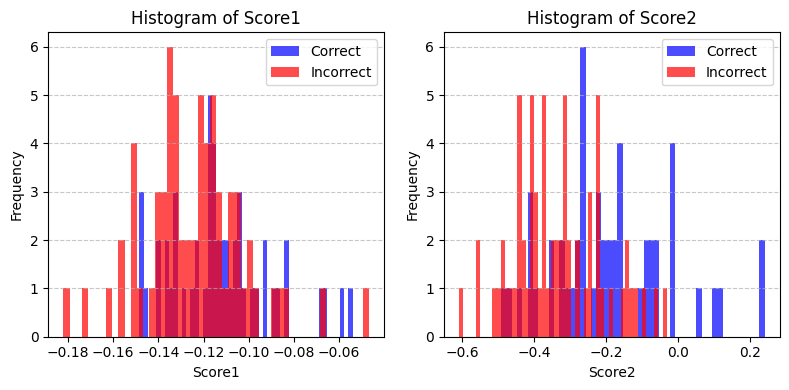

In [10]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Plot 2: Score1
axes[0].hist(correct_score1, bins=50, alpha=0.7, color='blue', label='Correct')
axes[0].hist(incorrect_score1, bins=50, alpha=0.7, color='red', label='Incorrect')
axes[0].set_title('Histogram of Score1')
axes[0].set_xlabel('Score1')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Score2
axes[1].hist(correct_score2, bins=50, alpha=0.7, color='blue', label='Correct')
axes[1].hist(incorrect_score2, bins=50, alpha=0.7, color='red', label='Incorrect')
axes[1].set_title('Histogram of Score2')
axes[1].set_xlabel('Score2')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [11]:
def evaluate_and_plot_roc(metrics):
    """
    metrics: List of tuples -> (metric_name, correct_scores, incorrect_scores)
    """
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))

    for ax, (title, correct, incorrect) in zip(axes.flatten(), metrics):
        # 1. 데이터 준비
        all_probs = correct + incorrect
        all_labels = [1] * len(correct) + [0] * len(incorrect)

        # 2. AUC 계산
        auc = roc_auc_score(all_labels, all_probs)

        # 3. ROC curve
        fpr, tpr, thresholds = roc_curve(all_labels, all_probs)

        # 4. Youden index → 최적 threshold
        youden_index = tpr - fpr
        optimal_idx = youden_index.argmax()
        optimal_threshold = thresholds[optimal_idx]
        #optimal_threshold = -1.0937

        # 5. Accuracy 계산
        predictions = [1 if prob >= optimal_threshold else 0 for prob in all_probs]
        correct_preds = sum(p == l for p, l in zip(predictions, all_labels))
        accuracy = correct_preds / len(all_labels)
        
        # Confusion matrix 구성
        TP = sum(1 for p, l in zip(predictions, all_labels) if p == 1 and l == 1)
        TN = sum(1 for p, l in zip(predictions, all_labels) if p == 0 and l == 0)
        FP = sum(1 for p, l in zip(predictions, all_labels) if p == 1 and l == 0)
        FN = sum(1 for p, l in zip(predictions, all_labels) if p == 0 and l == 1)

        # Precision, Recall, F1-score 계산
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0


        # 6. 시각화
        ax.plot(fpr, tpr, label=f"AUC = {auc:.4f}", color='blue')
        ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
        ax.set_title(f"{title}\nAcc: {accuracy:.4f}, F1: {f1:.4f}, Thresh: {optimal_threshold:.4f}")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

In [12]:
# 이미 수집된 Score 값들
metrics = [
    ("Score1", correct_score1, incorrect_score1),
    ("Score2", correct_score2, incorrect_score2),
]

evaluate_and_plot_roc(metrics)

In [34]:
### Accuarcy
optimal_threshold = optimal_threshold
# Classify probabilities using the optimal threshold
predictions = [1 if prob >= optimal_threshold else 0 for prob in all_probs]

# Calculate accuracy
accuracy = sum([1 if pred == label else 0 for pred, label in zip(predictions, all_labels)]) / len(all_labels)
print(f"Accuracy: {accuracy:.4f}")

# Confusion matrix 값 계산
TP = sum(1 for p, l in zip(predictions, all_labels) if p == 1 and l == 1)
TN = sum(1 for p, l in zip(predictions, all_labels) if p == 0 and l == 0)
FP = sum(1 for p, l in zip(predictions, all_labels) if p == 1 and l == 0)
FN = sum(1 for p, l in zip(predictions, all_labels) if p == 0 and l == 1)

# Precision, Recall, F1
precision = TP / (TP + FP) if (TP + FP) > 0 else 0.0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0.0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

#print(f"Precision: {precision:.4f}")
#print(f"Recall:    {recall:.4f}")
print(f"F1-score:  {f1:.4f}")


Accuracy: 0.7373
F1-score:  0.7480
